### Import libraries

In [1]:
import numpy as np                                 # library for arrays 
import pandas as pd                                # library for tables 
import geopandas as gpd                            # library for georeferenced tables 
from collections import OrderedDict                # ordered dictionary objects
import matplotlib.pyplot as plt                    # plotting library
import matplotlib.gridspec as gs                   # library to make gridded subplots
from matplotlib.pyplot import cm                   # colour management liibrary
import seaborn as sns                              # pretty statistical plotting library
import scipy.interpolate as intr                   # interpolation functions
from sklearn.linear_model import LinearRegression  # linear regression function
import utm                                         # conversion from and to UTM coordinates
from os import mkdir, path                         # operating system utilities

# this command displays plots below the related cell
%matplotlib inline

# # Alternatively, this command makes matplotlib open an interactive window everytime a figure is produced
# %matplotlib notebook 

sns.set(style='white', context='talk') # all plots have white background and large fontsize

### Specify input files and parameters

In [2]:
# Which is the name of the input folder for this simulation?
ipf = 'input_highsierra'

# Input rasters as ASCII files, with .txt or .asc extension
# Best resampled to a reasonably low resolution before importing it.
# If not, no big deal, but computational time increases
# Input Coordinate Reference System must be WGS1984
dem_filename = 'dem84.asc' # digital elevation model
e_map_filenames = [] # 'slope84.asc' # list of erosion maps with same extent as DEM, each cell has an erosional weigth

# watershed shapefile filename with .shp extension
# the input folder should also contain a .shx file with the same name,
# this is usually created during shapefile export from GIS software
ws_filename = 'inyo_ws.shp'

# Input bedrock ages filenames, with .xlsx extension
# This should be a table with the following header:
# lat, lon, elev, age, sd
bedrock_ages_filename = 'bd_highsierra.xlsx'
# Input detrital ages filenames, with .xlsx extension
# This should be a table with at least 2 columns with following headers: age, age_u
# where age_u = analytical uncertainty
detrital_ages_filenames = ['dd_inyo_fine.xlsx', 'dd_inyo_coarse.xlsx']

# Input target resolution of the interpolated surface [meters]
res = 90  

# How do you want to name the output folder for this simulation?
# files will be overwritten in case this folder already exists
opf = 'output_highsierra'

# What interpolation method do you want?
# Options are:
# 'rbf' - linear Radial Basis Function --> https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html#scipy.interpolate.Rbf
# 'int' - 3D linear interpolation --> https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html#scipy.interpolate.griddata
# 'ext' - like 'int', but additionally extrapolates ages outside of the interpolation convex hull (see below)
# 'zln' - each z gets assigned an age based on a linear regression of age-elevation data.
# 'imp' - import your own interpolated age map and uncertainty map (ASCII files referenced in WGS1984)
interp_method = 'zln'

# # If 'ext' is chosen, an inverse-distance-weight is used to assign ages
# # to the cells out of the linear interpolation field, but not farther than the search radius 'ext_rad'
# # which search radius do you want?
# # comment this line if not needed
# ext_rad = 3000 # meters

# # if 'imp' is chosen, specify the filenames to import from the input folder,
# # comment these lines if not needed
# age_map_filename = 'fake_age_map.txt' # interpolated age map .asc or .txt file
# age_map_u_filename = 'fake_age_map_u.txt'# map of interpolation uncertainty in %, .asc or .txt file

### Import input files and display them

In [3]:
########################## Open DEM and read the metadata ################################
##########################################################################################

# make DEM class
class DEM:
    def __init__(self, name):
        self.name = name

    def from_ascii(self, filename):
        '''
        Function to read an ASCII raster, most commonly exported from ArcGIS or QGIS.
        The first 6 lines must inform:

        ncols
        nrows
        xllcorner  
        yllcorner  
        cellsize   
        NODATA_value

        followed by the raster values separated by spaces

        if verbose=False, metadata is not printed, but only returned
        '''

        # read DEM text file
        fid = open(ipf+'/'+filename, 'r')

        # make a table of the dem info and convert values to suitable data types (integer, float)
        dem_info = [fid.readline().split() for i in range(6)]
        dem_info = np.array(dem_info).transpose()
        dem_info = dict([(k,v) for k,v in zip(dem_info[0],dem_info[1])])
        dtypes = (int,int,float,float,float,float)
        for i,f in zip(dem_info,dtypes):
            dem_info[i]=f(dem_info[i])

        # get the dem data as a list of strings
        dem_ls_of_str = [fid.readline().split() for i in range(dem_info['nrows'])]

        # then convert all strings to floats
        dem = np.array([[float(i) for i in dem_ls_of_str[j]] for j in range(dem_info['nrows'])])
        if dem.shape != (dem_info['nrows'], dem_info['ncols']):
            print('something went wrong while parsing the DEM, nrows and/or ncols do not match the original input')

        # change NODATA_value to np.nan, unless it equals 0
        if dem_info['NODATA_value'] != 0:
            dem[dem==dem_info['NODATA_value']]=np.nan
            dem_info['NODATA_value']=np.nan
            
        self.z = dem
        self.info_dict = dem_info
        # specify the figure's geographical extent in lat,lon
        self.xllcorner = dem_info['xllcorner']
        self.yllcorner = dem_info['yllcorner']
        self.ncols = dem_info['ncols']
        self.nrows = dem_info['nrows']
        self.cellsize = dem_info['cellsize']
        self.nodata = dem_info['NODATA_value']
        self.extent84 = (self.xllcorner, self.xllcorner+self.ncols*self.cellsize,
                         self.yllcorner, self.yllcorner+self.nrows*self.cellsize)
        
        # build coordinate grids and arrays
        # convert llcorner and urcorner coordinates to utm and define extentUTM
        self.xyll = utm.from_latlon(self.extent84[2], self.extent84[0]) #force_zone_number=19
        self.xyur = utm.from_latlon(self.extent84[3], self.extent84[1]) #force_zone_number=19
        self.extentUTM = (self.xyll[0], self.xyur[0], self.xyll[1], self.xyur[1])

        # make easting and northing vectors
        Xi = np.linspace(self.xyll[0], self.xyur[0], self.ncols)
        Yi = np.linspace(self.xyll[1], self.xyur[1], self.nrows)
        self.xi, yi = np.meshgrid(Xi,Yi)
        self.yi = yi[::-1] ################ flipped row order for latitude to decrease from top
        # 1d vectors, needed for linear interpolation
        self.xi_1d = self.xi.reshape(dem.size)
        self.yi_1d = self.yi.reshape(dem.size)
        self.zi_1d = dem.reshape(dem.size)
        
    def info(self):
        # Print details of imported DEM, except nodata value
        print('')
        print('METADATA OF '+self.name)
        print('')
        print('xllcorner = {}'.format(self.xllcorner))
        print('yllcorner = {}'.format(self.yllcorner))
        print('ncols = {}'.format(self.ncols))
        print('nrows = {}'.format(self.nrows))
        print('cellsize [km] = {}'.format(self.cellsize))
        print('cellsize [m] = ~{}'.format(int(np.around(self.cellsize*110000,1)/10)*10))
        print('min value = {}'.format(np.nanmin(self.z)))
        print('max value = {}'.format(np.nanmax(self.z)))
        print('NODATA_value = {}'.format(self.nodata))

    def resample(self, res, xyll=None, xyur=None, extent84=None, method='nearest'):
        '''
        Method to resample the input rasters to desired resolution .
        By default it uses a nearest neighbour algorithm
        res = resolution in meters
        xyll = (x,y) coordinates of lower left corner of target extent of the resampled dem
        xyur = (x,y) coordinates of upper right corner of target extent of the resampled dem
        extent84 = (left,right,bottom,top) in lon-lat, of the target extent of the resampled dem
        method --> https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html
        '''
        if xyll == None:
            xyll=self.xyll
        if xyur == None:
            xyur=self.xyur
        if extent84 == None:
            extent84=self.extent84
        # first make resampled easting and northing vectors
        Xi_res = np.arange(xyll[0], xyur[0]+res, res)
        Yi_res = np.arange(xyll[1], xyur[1]+res, res)
        self.xi_res, yi_res = np.meshgrid(Xi_res, Yi_res)
        self.yi_res = yi_res[::-1] ################# flipped row order for latitude to decrease from top
        self.xi_res_1d = self.xi_res.reshape(self.xi_res.size)
        self.yi_res_1d = self.yi_res.reshape(self.xi_res.size)

        # also make lon-lat vectors at same resolution
        Xi_res84 = np.linspace(extent84[0], extent84[1], self.xi_res.shape[1])
        Yi_res84 = np.linspace(extent84[2], extent84[3], self.xi_res.shape[0])
        self.xi_res84, yi_res84 = np.meshgrid(Xi_res84,Yi_res84)
        self.yi_res84 = yi_res84[::-1] ############## flipped row order for latitude to decrease from top

        # resample by interpolating at new grid nodes with resolution "res"
        # input_coords are organized in a 2D array, with columns representing x,y
        input_coords = np.concatenate(([self.xi_1d],[self.yi_1d])).transpose()
        # resampled coords are organized in a 2D array, with columns representing x,y
        self.res_coords = np.concatenate(([self.xi_res_1d],[self.yi_res_1d])).transpose()
        # Now resample: the 'values' variable refers to the known elevations of the input dem
        self.zi_res_1d = intr.griddata(points=input_coords, values=self.zi_1d, xi=self.res_coords, method=method)
        self.zi_res = self.zi_res_1d.reshape(self.xi_res.shape) # reshape from 1D to 2D
        
dem = DEM('topography')
dem.from_ascii(dem_filename)
dem.info()

# make dictionary of erosion maps
e_maps = {}

# fill it, if erosion maps are given
if len(e_map_filenames)>0:
    count=0
    for i in e_map_filenames:
        count+=1
        key = i[:i.find('.')]
        e_maps[key] = DEM(key)
        e_maps[key].from_ascii(i)
        e_maps[key].info()

    max_e = max([np.nanmax(m.z) for k,m in e_maps.items()])

# import interpolated age map and uncertainty, if given
if interp_method == 'imp':
    age_map = DEM('bedrock age')
    age_map.from_ascii(age_map_filename)
    age_map.info()
    age_map_u = DEM('bedrock age uncertainty')
    age_map_u.from_ascii(age_map_u_filename)
    age_map_u.info()


METADATA OF topography

xllcorner = -118.377601393217
yllcorner = 36.483606426649
ncols = 387
nrows = 170
cellsize [km] = 0.00090619439
cellsize [m] = ~90
min value = 1086.0
max value = 4405.0
NODATA_value = nan


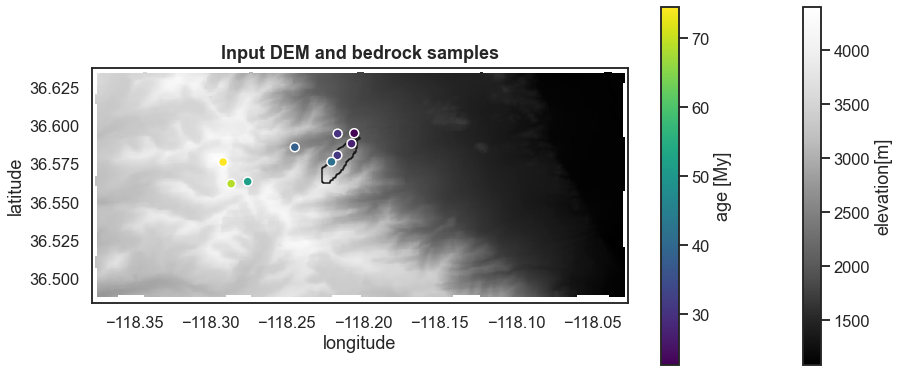

In [4]:
################# Now import age dataset into a pd.DataFrame ##############################
##########################################################################################
if interp_method != 'imp':
    bd = pd.read_excel(ipf+'/'+bedrock_ages_filename)

    z = bd.elev.values
    if z.mean()<10:
        z = z*1000 # convert elevations from km to meters, if that's the case
    a = bd.age.values
    u = bd.sd.values
    lat = bd.lat.values
    lon = bd.lon.values

    # convert from geographic to projected coordinates,
    # otherwise the interpolation will overestimate the role of elevation and produce funny results.
    # preallocate arrays
    x_utm = np.array([])
    y_utm = np.array([])
    for i,v in enumerate(lat):
        xy_utm = utm.from_latlon(lat[i], lon[i]) #force_zone_number=19
        x_utm = np.append(x_utm, xy_utm[0])
        y_utm = np.append(y_utm, xy_utm[1])

    # add points at -5000 m below sample elevation (zero cooling age depth) to arrays
    # such that each x,y location has a double with age=0 and elev=z-5000
    xx_utm = x_utm # double letters are the doubled vectors from now on (e.g. xx, yy...)
    yy_utm = y_utm
    zz = z
    aa = a
    for i,v in enumerate(z):
        xx_utm = np.append(xx_utm, x_utm[i])
        yy_utm = np.append(yy_utm, y_utm[i])
        zz = np.append(zz, v-5000)
        aa = np.append(aa, 1e-9)
    
################# Now import watershed outline as geopandas.DataFrame ##############################
##########################################################################################

ws_outline = gpd.read_file(ipf+'/'+ws_filename)

######################### Now plot dem and data points to check that everything worked fine ########
####################################################################################################

# make figure, gridspec and axes
# you can edit the parameter "figsize" if the aspect ratio doesn't fit
if len(e_map_filenames)>0:
    fig = plt.figure(figsize=(15,15*2*dem.nrows/dem.ncols))
    gspec = gs.GridSpec(2,len(e_maps.keys()),figure=fig)
else:
    fig = plt.figure(figsize=(15,15*dem.nrows/dem.ncols))
    gspec = gs.GridSpec(1,1,figure=fig)

# raster plot
ax1 = fig.add_subplot(gspec[0,:]) # first row of plot
im = ax1.imshow(dem.z, origin='upper', cmap='Greys_r', extent=dem.extent84)
# polygon plot
poly = ws_outline.plot(edgecolor='k',facecolor='None',ax=ax1)

ax1.set(aspect='equal', xlabel='longitude', ylabel='latitude',
        xlim=(dem.extent84[0],dem.extent84[1]), ylim=(dem.extent84[2],dem.extent84[3]))

# colorbar
cb1 = fig.colorbar(im)
cb1.set_label('elevation[m]')

# scatter plot if map of bedrock data was not imported
if interp_method != 'imp':
    ax1.set_title('Input DEM and bedrock samples',pad=10, fontdict=dict(weight='bold'))
    sct = ax1.scatter(lon, lat, c=a, cmap='viridis', edgecolor='w')
    cb2 = fig.colorbar(sct)
    cb2.set_label('age [My]')
else:
    ax1.set_title('Input DEM',pad=10, fontdict=dict(weight='bold'))


# plot imported erosional maps
if len(e_map_filenames)>0:
    count = 0
    row2 = []
    for k,i in e_maps.items():
        count+=1
        ax = fig.add_subplot(gspec[1,count-1])
        row2.append(ax)
        im2= ax.imshow(dem.z, origin='upper', cmap='Greys_r', extent=dem.extent84)
        em = ax.imshow(i.z, origin='upper', cmap='RdYlBu_r', extent=dem.extent84, alpha=0.5, vmin=0, vmax=max_e)
        ws_outline.plot(edgecolor='k',facecolor='None',ax=ax)
        ax.set_title('Erosion Map: '+k, fontdict=dict(weight='bold'))
        if count == gspec.get_geometry()[1]:
            cb3 = fig.colorbar(em,orientation='horizontal',ax=row2)
            cb3.set_label('erosivity')

# make output directory
if not path.exists(opf):
    mkdir(opf)

# and save figure
fig.savefig(opf+'/input_data.pdf', dpi=200)

if interp_method == 'imp':
    fig = plt.figure(figsize=(15,15))
    gspec = gs.GridSpec(2,1,figure=fig)
    ax1 = fig.add_subplot(gspec[0])
    ax2 = fig.add_subplot(gspec[1])
    im1 = ax1.imshow(age_map.z, extent=dem.extent84, cmap='viridis')
    ax1.set_title('Imported map of bedrock age',pad=10, fontdict=dict(weight='bold'))
    im2 = ax2.imshow(age_map_u.z, extent=dem.extent84)
    ax2.set_title('Imported map of bedrock age error',pad=10, fontdict=dict(weight='bold'))
    # colorbar
    cb1 = fig.colorbar(im1, ax=ax1)
    cb1.set_label('age [My]')
    cb2 = fig.colorbar(im2, ax=ax2)
    cb2.set_label('relative uncertainty [%]')
    
    # and save figure
    fig.savefig(opf+'/input_age_map.pdf', dpi=200)


### Resample DEM and interpolate ages to resampled topographic surface

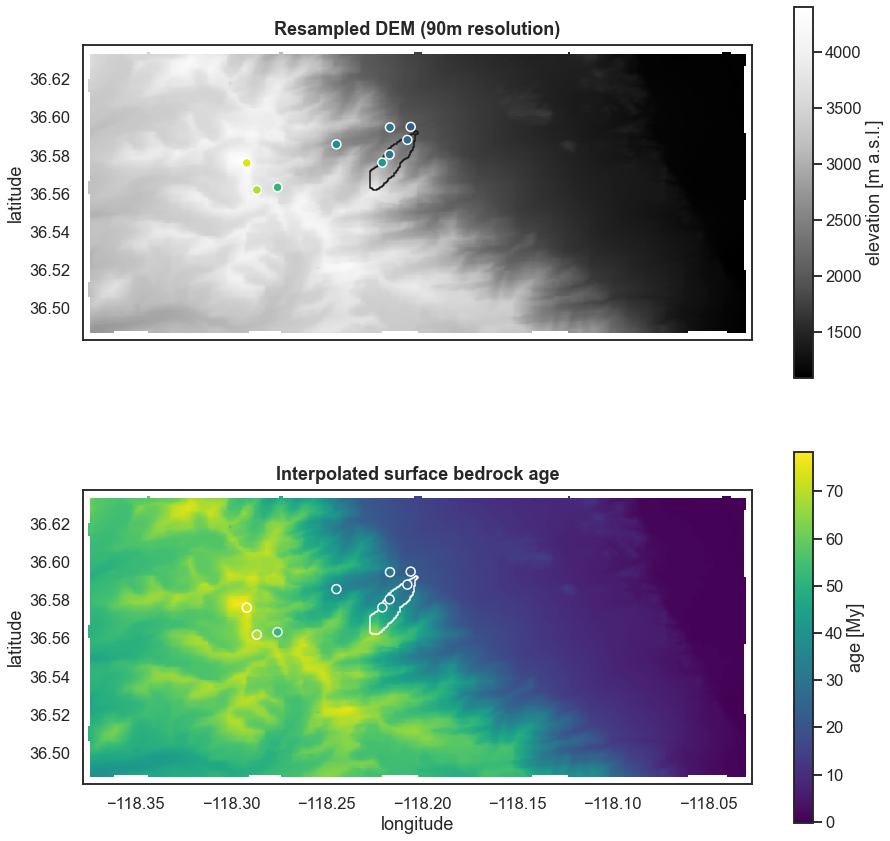

In [5]:
dem.resample(res)
if len(e_map_filenames)>0:
    for k,i in e_maps.items():
        i.resample(res, xyll=dem.xyll, xyur=dem.xyur, extent84=dem.extent84)

########################## Interpolate age data onto the topographic surface #######################
####################################################################################################
# Now run interpolation according to chosen method.

if interp_method =='imp':
    # resample age map
    age_map.resample(res, xyll=dem.xyll, xyur=dem.xyur, extent84=dem.extent84)
    age_interp_map = age_map.zi_res
    age_interp = age_map.zi_res_1d
    # resample age error map
    age_map_u.resample(res, xyll=dem.xyll, xyur=dem.xyur, extent84=dem.extent84)
    age_interp_error_map = age_map_u.zi_res    

elif interp_method == 'rbf':
    rbfi = intr.Rbf(xx_utm, yy_utm, zz, aa, function='linear')
    age_interp_map = rbfi(dem.xi_res, dem.yi_res, dem.zi_res)
    age_interp = age_interp_map.reshape(age_interp_map.size)
    
# simple linear regression from age-elevation data
elif interp_method == 'zln':
    reg = LinearRegression().fit(z.reshape(-1,1),a.reshape(-1,1))
#     age_interp_map = reg.intercept_ + reg.coef_ * dem.zi_res
    age_interp_map = 44.2+23.7*(dem.zi_res/1000-2.96)
    age_interp = age_interp_map.reshape(age_interp_map.size)

else:
    # known data points, for which the interpolation function is found
    # they are organized in a 2D array, with columns representing x,y,z
    pts = np.concatenate(([xx_utm],[yy_utm],[zz])).transpose()

    # positions where interpolation needs to be made (all the catchment's gridcells)
    # they are organized in a 2D array, with columns representing x,y,z
    pos = np.concatenate(([dem.xi_res_1d],[dem.yi_res_1d],[dem.zi_res_1d])).transpose()
    
    age_interp = intr.griddata(points=pts, values=aa, xi=pos)
    
    if interp_method == 'ext':
        def extrapolation(gdop, gdopx, gdopy, gdopz, data, datax, datay, dataz, ext_rad):
            '''
            Extrapolates data within wanted radius
            using an inverse distance weighted linear regression of the available data points
            input arguments:
            gdop: griddata output,
                  a 1D-array that contains the interpolated data
                  as well as the nans that you want to replace
            gdopx
            gdopy
            gdopz: 1D coordinate arrays of griddata output
            
            data: 1D-array of known ages 
            
            datax
            datay
            dataz: 1D coordinate arrays of known data points
            
            ext_rad: maximum extrapolation radius in meters
            '''

            # select nans from the griddata output 
            nans = gdop[gdop!=gdop]
            nansx = gdopx[gdop!=gdop]
            nansy = gdopy[gdop!=gdop]
            nansz = gdopz[gdop!=gdop]

            # define distance function
            def dist3D(xyz1, xyz2):
                '''
                Calculates the distance between two points in 3D.
                xyz1 - list or tuple of x,y,z coords for first point
                xyz2 - list or tuple of x,y,z coords for second point
                '''
                return np.sqrt((xyz1[0]-xyz2[0])**2+(xyz1[1]-xyz2[1])**2+(xyz1[2]-xyz2[2])**2)

            # This is the workflow of the extrapolation function:
            # for each of the nans:
            # calculate inverse distance from NaN to all samples, drop samples too far away
            # multiply inverse distances by related age and store in a [1 x M] vector of weighted values
            # summate and divide by M

            for i in np.arange(nans.size):
                # make array of ages divided by distance and number of data points
                dists = np.array([dist3D((nansx[i],nansy[i],nansz[i]),(datax[j],datay[j],dataz[j])) for j in np.arange(data.size)])
                dists1 = dists[dists < ext_rad] # do not consider points farther than extra_rad
                if dists1.size > 0:
                    data1 = data[dists < ext_rad] # select related ages 
                    dataz1 = dataz[dists < ext_rad]
                    dists1 = 1/dists1 # invert distances
                    # make linear regression based on age-elevation from data points within extra_rad
                    f_z = LinearRegression().fit(dataz1.reshape((-1,1)), data1, sample_weight=dists1)
                    nans[i] = f_z.intercept_+f_z.coef_*nansz[i]
                else:
                    nans[i] = np.nan

            # now substitute nans with extrapolated values
            gdop[gdop!=gdop] = nans
            return gdop

        # call the extrapolation function
        age_interp = extrapolation(age_interp, dem.xi_res_1d, dem.yi_res_1d, dem.zi_res_1d,
                                   a, x_utm, y_utm, z, ext_rad)
    # reshape to 2D    
    age_interp_map = age_interp.reshape(dem.zi_res.shape)
    
#################################### Plot it ##################################################
###################################################################################################
  
fig = plt.figure(figsize=(15,15))
gspec = gs.GridSpec(2,1,figure=fig)

ax1 = fig.add_subplot(gspec[0])

im1 = ax1.imshow(dem.zi_res, origin='upper', extent=dem.extent84, cmap='Greys_r')
ws_outline.plot(edgecolor='k',facecolor='None',ax=ax1)
ax1.set(aspect='equal', ylabel='latitude', xticks=[])
ax1.set_title('Resampled DEM ('+str(res)+'m resolution)', pad=10, fontdict=dict(weight='bold'))
cb = fig.colorbar(im1)
cb.set_label('elevation [m a.s.l.]')

ax2 = fig.add_subplot(gspec[1])

# plot bedrock surface age map
im2 = ax2.imshow(age_interp_map, origin='upper', extent=dem.extent84, cmap='viridis', alpha=1)

ws_outline.plot(edgecolor='w',facecolor='None',ax=ax2)
ax2.set(aspect='equal', xlabel='longitude', ylabel='latitude')
ax2.set_title('Interpolated surface bedrock age', pad=10, fontdict=dict(weight='bold'))
cb = fig.colorbar(im2)
cb.set_label('age [My]')


# plot samples and ages if interpolated map was not imported at the beginning
if interp_method != 'imp':
    for ax in [ax1,ax2]:
        ax.scatter(x=lon, y=lat, c=a, cmap='viridis',
                   vmin=np.nanmin(age_interp_map), vmax=np.nanmax(age_interp_map), edgecolor='w')
        ax.set(xlim=(dem.extent84[0],dem.extent84[1]), ylim=(dem.extent84[2],dem.extent84[3]))
# save fig
fig.savefig(opf+'/DEMres'+str(res)+'_ageinterp.pdf', dpi=200)

### Produce error map through bootstrapping

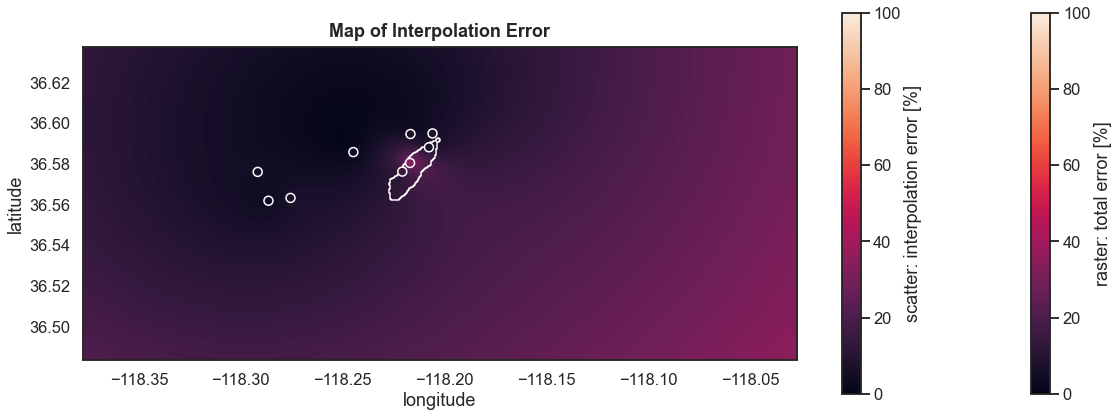

In [6]:
if interp_method != 'imp':
    # pre-allocate a vector with as many elements as bedrock samples
    error_interp = np.zeros(lat.size)

    # Bootstrap:
    # for each bedrock sample
    # 1. exclude the related point from input data
    # 2. calculate an interpolated surface age at its location
    # 3. save the difference to the known measured age.
    for i in np.arange(lat.size):
        a_boot = np.delete(aa, i)
        x_boot = np.delete(xx_utm, i)
        y_boot = np.delete(yy_utm, i)
        z_boot = np.delete(zz, i)

        # interpolate error with chosen method
        if interp_method == 'rbf':
            rbfi = intr.Rbf(x_boot, y_boot, z_boot, a_boot, function='linear')
            a_int = rbfi(xx_utm[i], yy_utm[i], zz[i]) # get interpolated age of excluded sample
        
        elif interp_method == 'zln':
            reg = LinearRegression().fit(z_boot.reshape(-1,1),a_boot.reshape(-1,1))
#             a_int = reg.intercept_ + reg.coef_ * zz[i]
            a_int = 44.2+23.7*(zz[i]/1000-2.96)

        else:
            pts1 = np.concatenate(([x_boot],[y_boot],[z_boot])).transpose() # data without i sample
            pos1 = np.concatenate(([xx_utm[i]], [yy_utm[i]], [zz[i]])) # coordinates of i sample
            a_int = intr.griddata(points=pts1, values=a_boot, xi=pos1)[0]

        error_interp[i] = abs(aa[i]-a_int)/aa[i]*100

    # calculate sqrt of the square error_interp + square age_sd
    error_total = np.sqrt(error_interp**2+(u/a*100)**2)
    # substitute nans at edge of interpolation with mean error
    error_total[error_total!=error_total] = np.nanmean(error_total)

    ##################### Now make the map by spatially interpolating known error points ##################
    #####################################################################################################

    # use chosen interpolation method
    if interp_method == 'rbf' or interp_method == 'zln':
        rbfi = intr.Rbf(x_utm, y_utm, error_interp, function='linear') # not considering elevation here
        age_interp_error_map = rbfi(dem.xi_res, dem.yi_res) # get interpolated age of excluded sample    

#     elif interp_method == 'zln':
#         reg = LinearRegression().fit(z.reshape(-1,1),error_interp.reshape(-1,1))
#         age_interp_error_map = reg.intercept_ + reg.coef_ * dem.zi_res
        
    else:
        pts_err = np.concatenate(([x_utm],[y_utm])).transpose()
        age_interp_error = intr.griddata(points=pts_err, values=error_total, xi=dem.res_coords)
        # preallocate array
        age_interp_error_map = np.ones(dem.zi_res.shape)
        for i in np.arange(age_interp_error.size):
            x_ind = int(np.rint((dem.xi_res_1d[i]-dem.xyll[0])/res))
            y_ind = int(np.rint((dem.yi_res_1d[i]-dem.xyll[1])/res))

            # assign nan if out of bounds
            if dem.zi_res[y_ind][x_ind] != dem.zi_res[y_ind][x_ind]:
                age_interp_error_map[y_ind][x_ind] = np.nan

            else:
                age_interp_error_map[y_ind][x_ind] = age_interp_error[i]

        age_interp_error_map = age_interp_error_map[::-1] # flipped to have correct latitude

        if interp_method == 'ext':
            # call the function
            extra_error = extrapolation(age_interp_error_map.reshape(age_interp_error_map.size),
                                        dem.xi_res_1d, dem.yi_res_1d, dem.zi_res_1d,
                                        error_total, x_utm, y_utm, z, ext_rad)
            age_interp_error_map = extra_error.reshape(dem.zi_res.shape)

##################################### Plot the error map ################################
#########################################################################################

fig,ax = plt.subplots(1,1,figsize=(20,7))

# plot error map
im = ax.imshow(age_interp_error_map, origin='upper', extent=dem.extent84, vmin=0, vmax=100)
ws_outline.plot(edgecolor='w',facecolor='None',ax=ax)
ax.set(aspect='equal', xlabel='longitude', ylabel='latitude',
       xlim=(dem.extent84[0],dem.extent84[1]), ylim=(dem.extent84[2],dem.extent84[3]))
ax.set_title('Map of Interpolation Error', pad=10, fontdict=dict(weight='bold'))

if interp_method == 'imp':
    cb = fig.colorbar(im)
    cb.set_label('bedrock age error [%]')
else:
    cb = fig.colorbar(im)
    cb.set_label('raster: total error [%]')
    sct = ax.scatter(x=lon, y=lat, c=error_total, edgecolor='w', vmin=0, vmax=100)
    cb1 = fig.colorbar(sct)
    cb1.set_label('scatter: interpolation error [%]')

# save fig
fig.savefig(opf+'/age_interp_error_map.pdf', dpi=200)

## Clip to watershed 

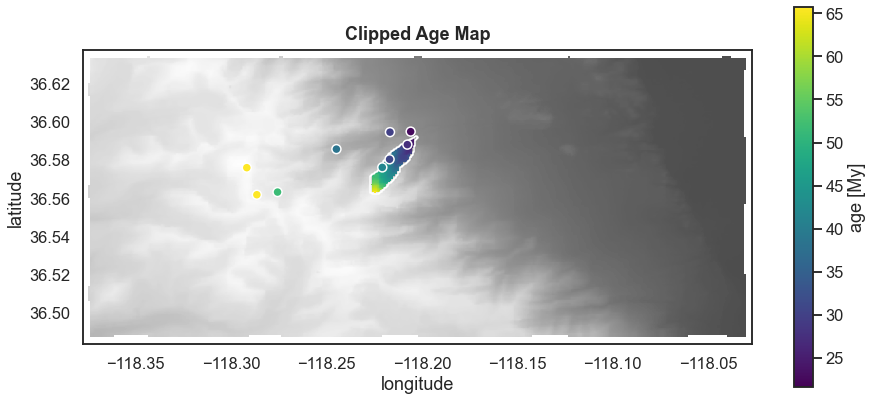

In [7]:
def clip_to_ws(raster, shp_filename, extent):
    '''
    This function clips the input raster to the watershed shapefile,
    so that all raster cells can be used to predict detrital distributions
    - raster: 2D np.array
    - shp_filename: string, filename of the watershed shapefile
    - extent: tuple or list, extent of the raster in wgs1984 (west, east, south, north)
    '''
    import fiona
    import rasterio
    from rasterio.plot import show
    from rasterio.mask import mask
    from shapely.geometry import Polygon
    
    # calculate x and y cellsize in degrees
    xsize = np.abs(extent[0]-extent[1])/raster.shape[1]
    ysize = np.abs(extent[2]-extent[3])/raster.shape[0]
    # define rasterio transform function
    transform = rasterio.transform.from_origin(extent[0], extent[3], xsize, ysize)
    # define coordinate reference system to wgs1984
    crs = rasterio.crs.CRS.from_epsg(4326) # wgs1984: 4326
    # make new raster file based on input, necessary step to use rasterio's functions,
    # and define the metadata
    src = rasterio.open(opf+'/raster.tif', 'w', driver='GTiff',
                        height = raster.shape[0], width = raster.shape[1],
                        count = 1, dtype = str(raster.dtype),
                        crs = crs, transform=transform)
    # write and close the new tif file
    src.write(raster, 1)
    src.close()
    # get watershed polygon vertices 
    with fiona.open(ipf+'/'+shp_filename,'r') as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]
    # read the raster and make masking information
    with rasterio.open(opf+'/raster.tif','r') as src:
        out_image, out_transform = mask(src, shapes, nodata=np.nan)
        out_meta = src.meta
    # update the metadata accordingly
    out_meta.update({"driver": "GTiff", "height": out_image.shape[1],
                     "width": out_image.shape[2], "transform": out_transform})
    # write the clipped raster
    with rasterio.open(opf+'/raster_clipped.tif', 'w', **out_meta) as dest:
        dest.write(out_image)
        
    return rasterio.open(opf+'/raster_clipped.tif').read(1)

# clip all rasters to watershed
xi_res_clp = clip_to_ws(dem.xi_res, ws_filename, dem.extent84)
yi_res_clp = clip_to_ws(dem.yi_res, ws_filename, dem.extent84)
zi_res_clp = clip_to_ws(dem.zi_res, ws_filename, dem.extent84)

if len(e_map_filenames)>0:
    e_maps_res_clp = dict()
    for k,i in e_maps.items():
        e_maps_res_clp[k] = clip_to_ws(i.zi_res, ws_filename, dem.extent84)

age_interp_map_clp = clip_to_ws(age_interp_map, ws_filename, dem.extent84)
age_interp_error_map_clp = clip_to_ws(age_interp_error_map, ws_filename, dem.extent84)

# plot the clipped age map
fig, ax = plt.subplots(figsize=(15,7))
ax.imshow(dem.zi_res, extent=dem.extent84, origin='upper', cmap='Greys_r', alpha=0.7)
im = ax.imshow(age_interp_map_clp, extent=dem.extent84, origin='upper', cmap='viridis')
ws_outline.plot(edgecolor='w',facecolor='None',ax=ax)
ax.set(aspect='equal', xlabel='longitude', ylabel='latitude',
       xlim=(dem.extent84[0],dem.extent84[1]), ylim=(dem.extent84[2],dem.extent84[3]))
ax.set_title('Clipped Age Map', pad=10, fontdict=dict(weight='bold'))
cb = fig.colorbar(im)
cb.set_label('age [My]')

if interp_method != 'imp':
    ax.scatter(x=lon, y=lat, c=a, edgecolor='w', cmap='viridis',
           vmin=np.nanmin(age_interp_map_clp), vmax=np.nanmax(age_interp_map_clp))

# save fig
fig.savefig(opf+'/clipped_age_map.pdf', dpi=200)

# age_interp_error_map = ws.read(1)
# age_interp_error = age_interp_error_map.reshape(age_interp_error_map.size)

## Make a table of x, y, elev, age, error, erosion

In [8]:
grids = [xi_res_clp, yi_res_clp, zi_res_clp, age_interp_map_clp, age_interp_error_map_clp] # grids to crop
labels = ['x', 'y', 'z', 'age', 'age_u%'] # labels for dictionary

# add labels and grids of the imported erosion maps
if len(e_map_filenames)>0:
    for k,i in e_maps_res_clp.items():
        labels.append(k)
        grids.append(i)

ws_data = pd.DataFrame()
for g,l in zip(grids,labels):
    if g[g==g].size != zi_res_clp[zi_res_clp==zi_res_clp].size:
        print('WARNING!!!')
        print('The number of no-data cells in the '+l+' raster must match that of the clipped DEM.')
        print('Please, make sure that the watershed polygon does not contain no-data.')
             
    
    ws_data[l] = g[g==g] # drop the nans and reshape to 1D-array

if len(e_map_filenames)>0:
    for k,i in e_maps_res_clp.items():
        ws_data[k] = ws_data[k]/ws_data[k].min() # minimum erosional weight should = 1

# # For the examples, make erosional weight as an exponential and inverse exponential function of elevation
# ws_data['E_exp_Z'] = np.exp(ws_data.z/ws_data.z.min())
# ws_data.E_exp_Z = ws_data.E_exp_Z/ws_data.E_exp_Z.min()
# ws_data['E_inv_exp_Z'] = 1/np.exp(ws_data.z/ws_data.z.min())
# ws_data.E_inv_exp_Z = ws_data.E_inv_exp_Z/ws_data.E_inv_exp_Z.min()

def Eriebe_fun(z):
    '''
    best-fit exponential function of elevation from Riebe et al. (2015)
    '''
    return 0.2*np.e**(2.1*(z/1000.0-2.96))

ws_data['Eriebe'] = ws_data.z.apply(Eriebe_fun)
ws_data.Eriebe = ws_data.Eriebe/ws_data.Eriebe.min()

# def estep(z):
#     if z<2500:
#         return 0.01
#     elif z<3500:
#         return 0.8
#     else:
#         return 0.2
    
# ws_data['E_step'] = ws_data.z.apply(estep)
# ws_data.E_step = ws_data.E_step/ws_data.E_step.min()

# save to excel
ws_data.to_excel(opf+'/xyz_age_eros.xlsx', index=False)

ws_data.head()

,x,y,z,age,age_u%,Eriebe
0,392349.026233,4.050262e+06,2053.0,22.7041,6.852209,1.108381
1,392439.026233,4.050262e+06,2004.0,21.5428,7.121050,1.000000
2,392169.026233,4.050172e+06,2136.0,24.6712,6.240697,1.319430
3,392259.026233,4.050172e+06,2109.0,24.0313,6.535624,1.246700
4,392349.026233,4.050172e+06,2076.0,23.2492,6.861290,1.163229


## Make grain populations for all erosion scenarios and related distributions

In [9]:
ws_data = pd.read_excel(opf+'/xyz_age_eros.xlsx')

# make populations according to the different erosion weighting
multiplier = 10 # starting number of grains for each cell (the more the better, but also slower...)
pops = OrderedDict() # preallocate dictionary of populations
scen_labels = ws_data.columns[5:].to_list() # ['E_exp_Z','E_inv_exp_Z','E_map']
for s in scen_labels:
    # label of the column that informs how many grains (N) per cell
    N_label = 'N_'+s
    # assign to each cell an amount of grains proportional to the erosional weight
    ws_data[N_label] = np.rint(ws_data[s]*multiplier)
    # make a gaussian distribution for each cell
    # Draw from it as many ages as grains and store them in a 1D-array, in the populations dictionary
    pops[s] = np.array([])
    for A,u,N in zip(ws_data.age, ws_data['age_u%'], ws_data[N_label]):
        pops[s] = np.append(pops[s], np.random.normal(A,np.abs(A*u/100),int(N)))

# make uniform erosion population in the same way
ws_data['N_Euni'] = np.ones(len(ws_data))*multiplier
pops['Euni'] = np.array([])
for A,u,N in zip(ws_data.age, ws_data['age_u%'], ws_data['N_Euni']):
    pops['Euni'] = np.append(pops['Euni'], np.random.normal(A,np.abs(A*u/100),int(N)))

# move Euni to the beginning
pops.move_to_end('Euni', last=False)

# also load the detrital data and make populations
dd = OrderedDict()
detr_labels = []
for file in detrital_ages_filenames:
    detr_label = file[:file.find('.')]
    detr_labels.append(detr_label)
    dd[detr_label] = pd.read_excel(ipf+'/'+file)
    pops[detr_label] = dd[detr_label].age.values

# define cdf function
def make_dists(pop):
    '''
    makes a normalized cdf of input population
    returns a dataframe with values, counts, frequency
    - pop: 1D np.array of ages, or list of ages
    '''
    pop = np.array(pop) # make array
    df = pd.DataFrame() # initialise dataframe
    df['vals'], df['valcount'] = np.unique(pop, return_counts=True)
    df.index = df.vals.apply(int) # use ages as index
    df['cdf_y'] = df.valcount.cumsum()/df.valcount.cumsum().iloc[-1] # make cumulative frequency
    return df
    
# define spdf function
def make_spdf(pop,sd=0.05):
    '''
    spdf (synoptic probability density function) equation
    from Ruhl & Hodges 2003, Vermeesch 2007, Riebe et al. 2015
    
    pop = 1d-array of grain ages
    sd = list/array of sigma1, or scalar informing preassigned 1sigma (e.g. 0.05 = 5% uncertainty)
    
    returns 1d-array where each element informs the frequency of the respective sorted value from
    '''
    pop = np.array(pop)
    if np.isscalar(sd):
        sigma1 = np.array([t*sd for t in pop])
    else:
        sigma1 = np.array(sd)
    vals = np.unique(pop, return_counts=False)
    spdf_y = [1.0/pop.size*np.sum(np.array([np.sqrt(2.0*np.pi)*u*np.exp((t-ti)**2.0/(2.0*u**2.0))
                                            for ti,u in zip(pop,sigma1)])**-1) for t in vals]
    return np.array(spdf_y)

# preallocate dictionary of distributions
dists = OrderedDict()
for label, pop in pops.items():
    dists[label] = make_dists(pop)

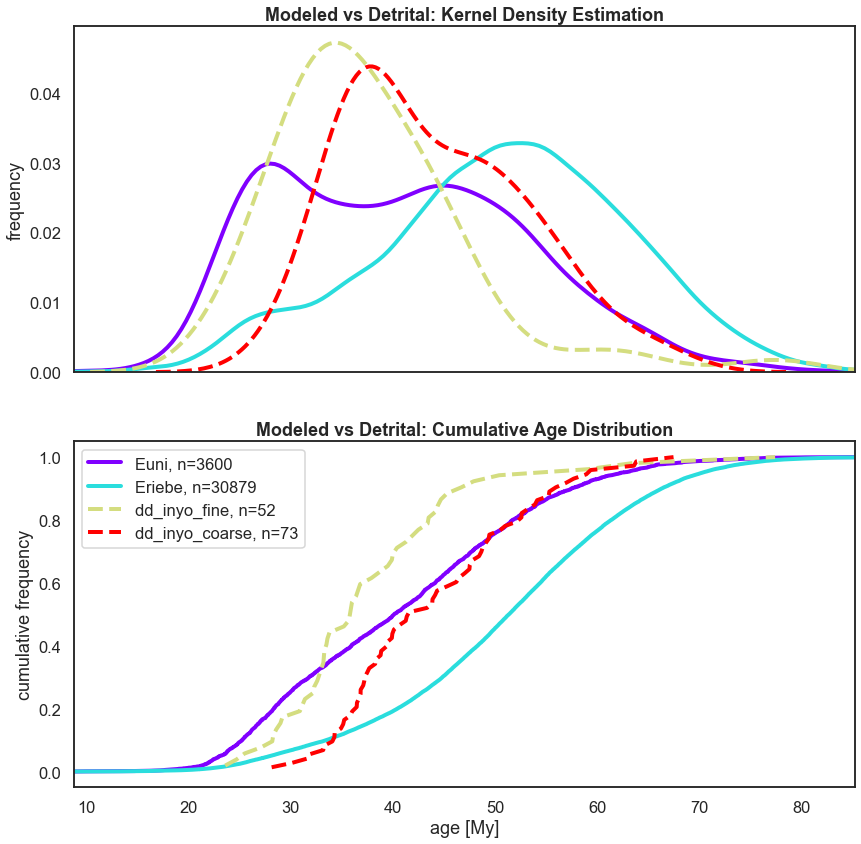

In [10]:
##################################### Plot distributions ################################
#########################################################################################
# define which is the reference erosion scenario
ref_scen = 'Euni'

fig = plt.figure(figsize=(14,14))
gspec = gs.GridSpec(2,1,figure=fig)
ax1 = fig.add_subplot(gspec[0])

# plot all scenarios spdf
color=iter(cm.rainbow(np.linspace(0,1,len(dists)))) # np.linspace(0,1,len(scen_labels))
xlim = (pops[ref_scen].min(), pops[ref_scen].max())

for scen,df in dists.items():
    if sum([i==scen for i in detr_labels])>0:
        ls='--'
    else:
        ls='-'
    sns.kdeplot(pops[scen], color=next(color), linewidth=4, linestyle=ls, label='_nolegend_', ax=ax1)
#     sns.distplot(pops[scen],hist=False,
#                      kde_kws={'color':next(color),'linewidth':4,'linestyle':ls},label='_nolegend_', ax=ax1)
    ax1.set(xlim=xlim, ylabel='frequency', xlabel='', xticks=[])
    ax1.set_title('Modeled vs Detrital: Kernel Density Estimation',
                 fontdict={'weight':'bold'})

# second row
ax2 = fig.add_subplot(gspec[1])

color=iter(cm.rainbow(np.linspace(0,1,len(dists))))
c_ref = next(color)

# # plot all scenarios cdf, including 100 random subsamples of reference scenario?
# sample_size = 50
# for i in np.arange(100):
#     pop1 = np.random.choice(pops[ref_scen],sample_size)
#     if i==0:
#         dist1 = make_dists(pop1)
#         sns.lineplot(dist1.vals,dist1.cdf_y,
#                      color=c_ref, alpha=0.1, lw=1, ax=ax2, label=ref_scen+', n='+str(sample_size))
#     else:
#         dist1 = make_dists(pop1)
#         sns.lineplot(dist1.vals, dist1.cdf_y,
#                      color=c_ref, alpha=0.1, lw=1, ax=ax2, label='_nolegend_')

color=iter(cm.rainbow(np.linspace(0,1,len(dists)))) # np.linspace(0,1,len(scen_labels))
for scen,df in dists.items():    
    if sum([i==scen for i in detr_labels])>0:
        ls = '--'
    else:
        ls = '-'
    ax2.plot(df.vals, df.cdf_y, color=next(color), linestyle=ls, label=scen+', n='+str(df.valcount.sum()), lw=4)
ax2.set(xlim=xlim, ylabel='cumulative frequency', xlabel='age [My]')
ax2.set_title('Modeled vs Detrital: Cumulative Age Distribution',
                 fontdict={'weight':'bold'})
ax2.legend()

# save fig
fig.savefig(opf+'/detrital_distributions.pdf', dpi=200)

## Confidence in discerning between erosion scenarios and 'Euni'
## as a function of sample size.

In [11]:
def get_KS(res_p, d):
    '''
    res_p = resampled population p, with n=k
    d = real distribution of p
    returns KS statistic
    '''
    res_p = np.array(res_p)
    res_p.sort()
    res_p_vals, res_p_valcount = np.unique(res_p, return_counts=True)

    res_d = res_p_valcount.cumsum()/res_p_valcount.sum()
    # return KS statistic between real and interpolated from downsampled
    return max(np.abs(np.interp(x=res_p_vals,xp=d.vals,fp=d.cdf_y)-res_d))

def get_KL(res_p, d):
    '''
    res_p = resampled population p, with n=k
    d = real distribution of p
    bounds = limits of the distribution, defined at the beginning
    returns characteristic KL divergence at the chosen confidence level
    '''
    from scipy.stats import entropy
    res_p = np.array(res_p)
    res_p.sort()
    res_p_vals, res_p_valcount = np.unique(res_p, return_counts=True)
    res_d = res_p_valcount.cumsum()/res_p_valcount.sum()
    # return KL divergence between real and interpolated from downsampled
    return entropy(np.interp(x=res_p_vals,xp=d.vals,fp=d.cdf_y), res_d)


# Assign variables for iterations
all_k = np.arange(30,150,10) # possible N of dated grains (k) to consider
k_iter = 1000 # iterations per k value

# which statistic to be used? [get_KS, 'KS statistic'] , [get_KL,'KL divergence']  
stat = [get_KS, 'KS statistic']

# calculate 95% confidence divergence for each k, between 'Euni' n=∞ and 'Euni' n=size of dd
Dc_within = {} # critical divergence between the reference scenario and the subsampled itself
D_dist_dict = {} # store distributions for later confidence plot
Dc = []
for k in all_k:
    # make array of integers (all equal k) with length k_iter
    k_array = (np.ones(k_iter)*k).astype(int)
    # get array of random divergencies, using chosen statistic
    D_arr = np.array([stat[0](np.random.choice(pops[ref_scen],k),dists[ref_scen]) for k in k_array])
    # sort values
    D_arr.sort()
    # calculate cumulative probability of each value
    D_arr_vals, D_arr_valcount = np.unique(D_arr, return_counts=True)
    D_arr_prob = D_arr_valcount.cumsum()/D_arr_valcount.sum()
    ind95 = np.where(D_arr_prob<=0.95)[0][-1] # index of the 95th percentile
    # store values
    Dc.append(D_arr_vals[ind95])
    D_dist_dict[ref_scen+'_'+str(k)] = [D_arr_vals, D_arr_prob, D_arr]
Dc_within[ref_scen] = Dc

for scen in scen_labels:
    Dc = []
    for k in all_k:
        # make array of integers (all equal k) with length k_iter
        k_array = np.round(np.ones(k_iter)*k).astype(int)
        # get array of random divergences, using chosen statistic
        D_arr = np.array([stat[0](np.random.choice(pops[scen],k),dists[ref_scen]) for k in k_array])
        # sort values
        D_arr.sort()
        # calculate cumulative probability of each value
        D_arr_vals, D_arr_valcount = np.unique(D_arr, return_counts=True)
        D_arr_prob = D_arr_valcount.cumsum()/D_arr_valcount.sum()
        D_dist_dict[scen+'_'+str(k)] = [D_arr_vals, D_arr_prob, D_arr]

################ Calculate the confidence as function of the number of grains ########################
###############################################################################################

# Compare Dc_within to all scenarios for all k
# and get the probability of a scenario being discerned from reference for each k
probs = {}
for scen in scen_labels:
    probs1 = []
    for i in np.arange(len(all_k)): # for all k values
        # get index of element where Dc_within is smaller than Dc_between
        ind = np.where(D_dist_dict[scen+'_'+str(all_k[i])][0]>Dc_within[ref_scen][i])[0][0]
        # get complementary probability of ind,
        # because we're interested in how many values are larger than that (not smaller)
        probs1.append(100*(1-D_dist_dict[scen+'_'+str(all_k[i])][1][ind])) 
    probs[scen] = probs1

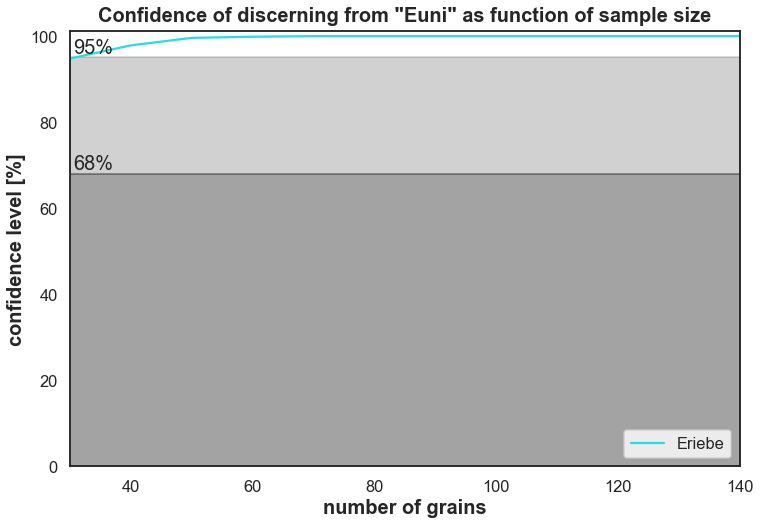

In [12]:
################ Plot the confidence as function of grain number ########################
#########################################################################################

def smooth(y, window_size=3, order=1, deriv=0, rate=1):
    '''
    dirty smoothing function, so that curves can be calculated on the base of ~1000 iterations,
    but still look good, if wanted
    '''
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        print("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y1 = np.concatenate((firstvals, y, lastvals))
    y_new = np.convolve( m[::-1], y1, mode='valid')
    y_new[0] = y[0]
    return y_new

def plot_confidence(prob_dict, all_k, saveas='scenarios_confidence_sample_size.pdf'):
    '''
    plots the confidence level as function of sample size
    prob_dict: dictionary of arrays, each containing confidence values related to all_k
    all_k: 1D-array of k values (integers)
    '''
    sns.set_style('white')
    fig,ax = plt.subplots(figsize=(12,8))
    # plot grey fields
    ax.fill_between([all_k[0],all_k[-1]],[95,95],[68,68],color='k',alpha=0.2)
    ax.text(all_k[0]+0.5,96,'95%',fontdict=dict(size=20))
    ax.fill_between([all_k[0],all_k[-1]],[68,68],color='k',alpha=0.4)
    ax.text(all_k[0]+0.5,69,'68%',fontdict=dict(size=20))
    color=iter(cm.rainbow(np.linspace(0,1,len(dists))))
    next(color) # skip one color for Euni
    leg=[]
    for key,i in prob_dict.items():
        c = next(color)
        ax.plot(all_k,
                smooth(i),
                c=c,
                alpha=1)
        leg.append(key)
    ax.set(xlim=(all_k[0],all_k[-1]), ylim=(0,101), yticks=[0,20,40,60,80,100])
    ax.set_xlabel('number of grains',fontdict=dict(size=20, weight='bold'))
    ax.set_ylabel('confidence level [%]',fontdict=dict(size=20, weight='bold'))
    ax.set_title('Confidence of discerning from "'+ref_scen+'" as function of sample size',
                 fontdict=dict(size=20,weight='bold'), pad=10)
    ax.legend(leg, loc='lower right')
    
    fig.savefig(opf+'/'+saveas, dpi=200)
    
plot_confidence(prob_dict=probs, all_k=all_k)

## How do the different scenarios fit to the detrital data?

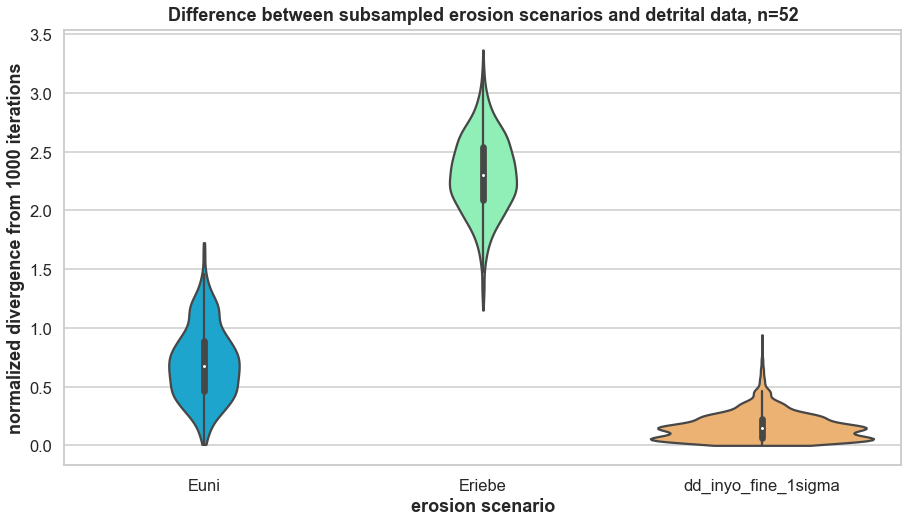

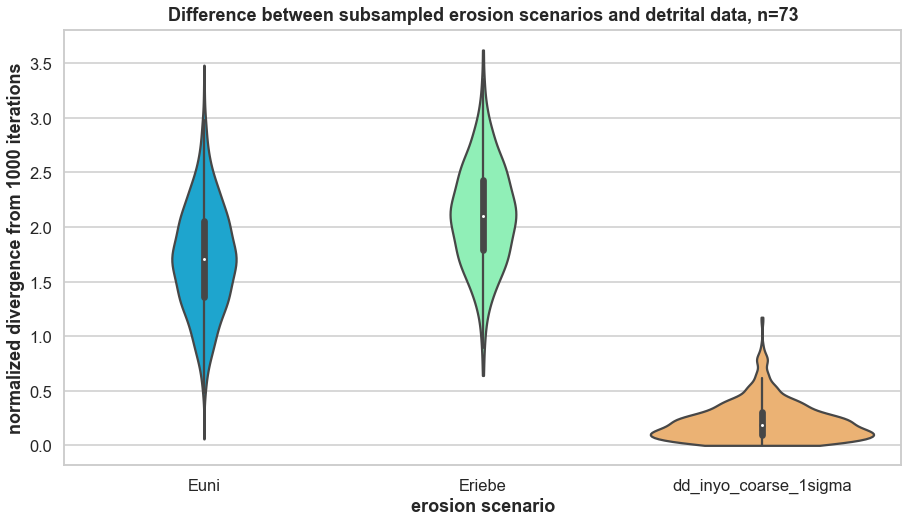

In [17]:
# allocate dictionary to store all iteration results
iter_results = OrderedDict()
for k,i in dd.items():
    pops.pop(k, None) # remove detrital populations from dictionary, it is still to be found as dd['_label_'].age.values

# make a detrital population that takes analytical uncertainty into account and see how it compares to scenarios
pops_1sigma = OrderedDict()
for k,i in dd.items():
    # allocate dataframe to store all iteration results
    iter_results[k+'_1sigma'] = pd.DataFrame(columns=['divergence','metric','scenario'])
    KS_list = [] # empty list to receive KS statistic of each iteration
    scenario_list = [] # empty list to receive scenario name of each iteration

    pop_1sigma = np.array([])
    for j in i.index:
        # for each measured detrital age, make a normally distributed n=100 population based on the analitical error
        # and add it to the total population
        pop_1sigma = np.append(pop_1sigma,np.random.normal(i.loc[j].age,i.loc[j].age_u,100))
        
    # store population
    pops_1sigma[k+'_1sigma'] = pop_1sigma
    
    # array of sample sizes, all equal to number of measured grains
    k_array = np.round(np.ones(k_iter)*len(i)).astype(int)

    # iterate through erosion scenarios
    for label,pop in pops.items():
        KS_list = KS_list + [get_KS(np.random.choice(pop,num),dists[k]) for num in k_array]
        scenario_list = scenario_list + [label for ii in k_array]
        
    # and do the same analysis for the new pop_1sigma
    KS_list = KS_list + [get_KS(np.random.choice(pop_1sigma,num),dists[k]) for num in k_array]
    scenario_list = scenario_list + [k+'_1sigma' for ii in k_array]
    
    # write dataframe
    iter_results[k+'_1sigma'].divergence = KS_list
    iter_results[k+'_1sigma'].metric = ['KS statistic' for ii in KS_list]
    iter_results[k+'_1sigma'].scenario = scenario_list
    
    # make column of divergence normalized to mean of each metric
    KS_arr = np.array(KS_list)
    KS_dd_med = iter_results[k+'_1sigma'].where((iter_results[k+'_1sigma'].metric=='KS statistic')&
                                   (iter_results[k+'_1sigma'].scenario==k+'_1sigma')).divergence.median()
    iter_results[k+'_1sigma']['divergence_norm'] = np.abs(KS_arr-KS_dd_med)/KS_arr.std()

    sns.set_style('whitegrid')
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot()

    # only use KS?
    data4violins = iter_results[k+'_1sigma'][iter_results[k+'_1sigma']['metric']=='KS statistic'].copy()

    sns.violinplot(data=data4violins, x='scenario',y='divergence_norm', ax=ax,
                   cut=0, scale='area', palette='rainbow') #sns.color_palette('colorblind')

    ax.set_xlabel('erosion scenario', fontdict={'weight':'bold'})
    ax.set_ylabel('normalized divergence from '+str(k_iter)+' iterations',fontdict={'weight':'bold'})
    ax.set_title('Difference between subsampled erosion scenarios and detrital data, n='+str(len(i)),
                 pad=10, fontdict={'weight':'bold'})
    # save figure
    fig.savefig(opf+'/fit_to_'+k+'_data_violinplot.pdf', dpi=200)

## 3D Plotting example

In [ ]:
# from matplotlib.colors import LightSource

# %matplotlib notebook

# # Set up plot
# fig, ax = plt.subplots(subplot_kw=dict(projection='3d'),figsize=(10,5))

# ls = LightSource(80,20)
# # To use a custom hillshading mode, override the built-in shading and pass
# # in the rgb colors of the shaded surface calculated from "shade".
# rgb = ls.shade(zi_res, cmap=cm.gist_earth,vert_exag=0.3,
#                blend_mode='soft',vmax=2200)
# surf = ax.plot_surface(xi_res84,yi_res84[::-1],zi_res,facecolors=rgb,
#                        linewidth=0, antialiased=False, shade=True)
# ax.set(xticks=[-71.2,-71.1,-71],yticks=[-33,-32.95,-32.9],zticks=[500,1000,1500,2000])
# ax.view_init(70, 115) #50,195

## Multidimensional Scaling

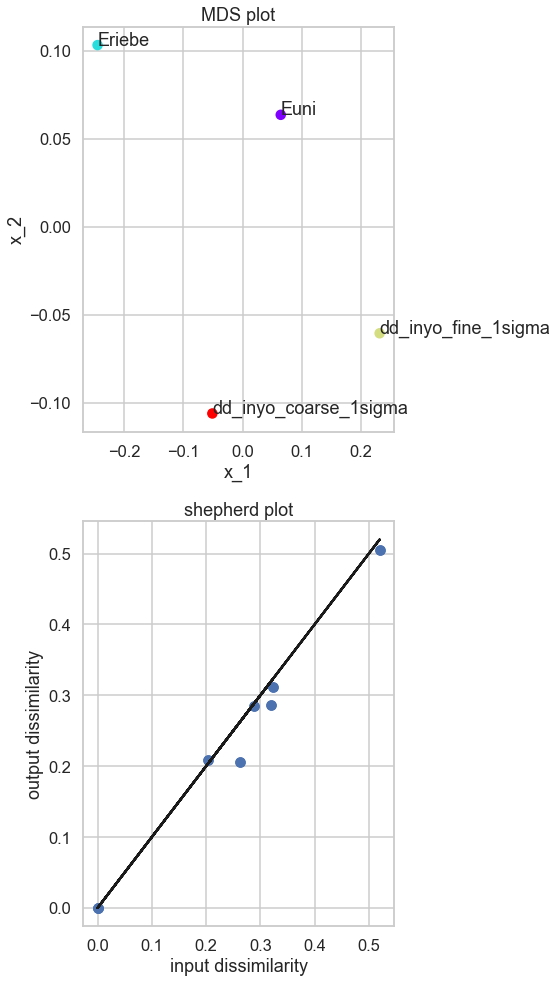

In [22]:
# add back the detrital populations to the dictionary
for k,i in pops_1sigma.items():
    pops[k] = i

l = list(pops.keys())
n = len(l)
diss = np.zeros((n,n))

for i in np.arange(n):
    for j in np.arange(n):
        diss[i,j] = get_KS(pops[l[i]], make_dists(pops[l[j]]))
for i in np.arange(n):
    for j in np.arange(n):
        diss[j,i] = diss[i,j]

from sklearn.manifold import MDS
mmds = MDS(n_components=3, metric=True, dissimilarity='precomputed',eps=1e-9)
# nmds = MDS(n_components=2, metric=False, dissimilarity='precomputed',eps=1e-3)
x = mmds.fit(diss)

# xn = nmds.fit(diss)
# plt.scatter(xn.embedding_[:,0],xn.embedding_[:,1], c=np.arange(n), cmap='rainbow', marker='s')

# visualize dissimilarities in a 2D plot
fig,ax = plt.subplots(2,1,figsize=(8,14))
ax[0].scatter(x.embedding_[:,0],x.embedding_[:,1], c=np.arange(n), cmap='rainbow')
for X,Y,l in zip(x.embedding_[:,0],x.embedding_[:,1],l):
    ax[0].annotate(l,(X,Y))
ax[0].set(title='MDS plot', xlabel='x_1', ylabel='x_2')

# calculate distance between points based on MDS results
diss_emb = diss.copy()
for i in np.arange(n):
    for j in np.arange(n):
        diss_emb[i,j] = np.sqrt((x.embedding_[i,0]-x.embedding_[j,0])**2+(x.embedding_[i,1]-x.embedding_[j,1])**2)

        # plot input dissimilarities / distances against modeled ones, to see how good the model performs
ax[1].plot(diss.reshape(diss.size), diss.reshape(diss.size),'k')
ax[1].scatter(diss.reshape(diss.size), diss_emb.reshape(diss.size))
ax[1].set(title='shepherd plot', xlabel='input dissimilarity', ylabel='output dissimilarity')

plt.tight_layout()

In [ ]:
# # vermeesch_data
# vd = pd.read_csv('/Users/andrea/Downloads/DZages.csv')

# l = list(vd.columns)
# n = len(l)
# diss = np.zeros((n,n))

# for i in np.arange(n):
#     for j in np.arange(n):
#         diss[i,j] = get_KS(vd[l[i]].dropna(), make_dists(vd[l[j]].dropna()))
# for i in np.arange(n):
#     for j in np.arange(n):
#         diss[j,i] = diss[i,j]
# #diss=np.around(diss)

# from sklearn.manifold import MDS
# cmds = MDS(n_components=2, metric=True, dissimilarity='precomputed', eps=1e-9)
# nmds = MDS(n_components=2, metric=False, dissimilarity='precomputed', eps=1e-3)
# x = cmds.fit(diss)
# xn = nmds.fit(diss)

# plt.scatter(x.embedding_[:,0],x.embedding_[:,1], c=np.arange(n), cmap='rainbow', label=vd.columns)
# #plt.scatter(xn.embedding_[:,0],xn.embedding_[:,1], c=np.arange(n), cmap='rainbow', marker='s')

# for x,y,l in zip(x.embedding_[:,0],x.embedding_[:,1],vd.columns):
#     plt.annotate(l,(x,y))